In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

# import os
# if os.name == 'posix' :
#     plt.rc('font', family='AppleGothic')
# else :
#     plt.rc('font', family='Malgun Gothic')
    
plt.rc('axes', unicode_minus=False)

plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

## 데이터 불러오기

In [2]:
user_df = pd.read_parquet('./votes/accounts_user.parquet')
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [3]:
userquestion_df = pd.read_parquet('./votes/accounts_userquestionrecord.parquet')
userquestion_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [4]:
userquestion_567_df = userquestion_df[(userquestion_df['created_at']>='2023-05-01') & (userquestion_df['created_at']<'2023-08-01')]

In [5]:
school_df = pd.read_parquet('./votes/accounts_school.parquet')
school_df.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [6]:
group_df = pd.read_parquet('./votes/accounts_group.parquet')
group_df.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [7]:
group_df.describe()

,id,grade,class_num,school_id
count,84515.000000,84515.000000,84515.000000,84515.000000
mean,42279.376087,2.113992,5.318606,3079.496468
std,24400.962630,0.754896,4.089901,1675.036093
min,1.000000,1.000000,0.000000,1.000000
25%,21147.500000,2.000000,2.000000,1752.000000
50%,42279.000000,2.000000,4.000000,3023.000000
75%,63411.500000,3.000000,7.000000,4620.000000
max,84546.000000,20.000000,41.000000,5965.000000


In [8]:
# 3학년 이상인 데이터 수
group_df[group_df['grade'] > 3]

,id,grade,class_num,school_id
32624,32644,4,10,4658
61622,61647,20,7,3867


In [9]:
# 0반 데이터 수 
group_df[group_df['class_num'] == 0]

,id,grade,class_num,school_id
62234,62259,2,0,4348
62626,62651,2,0,1820


In [10]:
# 20반 보다 큰 수 확인
group_df[group_df['class_num'] > 20]

,id,grade,class_num,school_id
70368,70394,1,41,736


- 이상치 제거
    - grade : 4학년, 20학년 제외
    - class_num : 0반, 41반 제외

In [11]:
# 이상치 제거 하기
group_df = group_df[(group_df['grade'] <= 3) & (group_df['class_num'] <= 20) & (group_df['class_num'] > 0) ]

---

## 데이터 전처리 (합치기, 추출하기 등)

### 10개 학교 데이터로 뽑기

In [12]:
# school_id, group_id 테이블 합치기
school_group_df = pd.merge(group_df, school_df, left_on='school_id', right_on='id', how='left')
school_group_df = school_group_df.drop(columns=['class_num', 'id_y'])
school_group_df = school_group_df.rename(columns={'id_x':'group_id'})
school_group_df.head()

,group_id,grade,school_id,address,student_count,school_type
0,1,1,1,NaN,NaN,NaN
1,8,3,1,NaN,NaN,NaN
2,9,3,1,NaN,NaN,NaN
3,10,2,1,NaN,NaN,NaN
4,11,2,1,NaN,NaN,NaN


In [13]:
user_group_df = user_df[['id', 'group_id']]
user_school_df = pd.merge(user_group_df, school_group_df, on='group_id', how='left')
user_school_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,NaN,NaN,NaN,NaN,NaN,NaN
1,831962,12.0,2.0,1.0,NaN,NaN,NaN
2,832151,1.0,1.0,1.0,NaN,NaN,NaN
3,832340,1.0,1.0,1.0,NaN,NaN,NaN
4,832520,12.0,2.0,1.0,NaN,NaN,NaN


In [14]:
# 결측치를 0으로 채워서 사라지지 않게 하기
user_school_fillna_df = user_school_df.copy()
user_school_fillna_df = user_school_fillna_df.fillna(0)

In [15]:
user_school_fillna_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,0.0,0.0,0.0,0,0.0,0
1,831962,12.0,2.0,1.0,0,0.0,0
2,832151,1.0,1.0,1.0,0,0.0,0
3,832340,1.0,1.0,1.0,0,0.0,0
4,832520,12.0,2.0,1.0,0,0.0,0


In [16]:
# 투표 기록 테이블에 학교 정보 합치기
userquestion_school_df = pd.merge(userquestion_df, user_school_fillna_df, left_on='user_id', right_on='id', how='left')
userquestion_school_df.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,id_y,group_id,grade,school_id,address,student_count,school_type
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0,849436,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [17]:
# 필요없는 컬럼 삭제하기
userquestion_school_df = userquestion_school_df.drop(columns=['id_x','report_count', 'opened_times', 'id_y'])
userquestion_school_df.head()

,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,group_id,grade,school_id,address,student_count,school_type
0,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
1,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
2,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
3,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H
4,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,356.0,2.0,271.0,충청남도 천안시 서북구,491.0,H


In [18]:
# 학교 수 확인해보기
userquestion_school_df['school_id'].nunique()

10

In [19]:
# 5~7월 데이터로만 추출
userquestion_school_567_df = userquestion_school_df[(userquestion_school_df['created_at'].dt.year == 2023)&(userquestion_school_df['created_at'].dt.month.isin([5,6,7]))]
userquestion_school_567_df.head()

,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,group_id,grade,school_id,address,student_count,school_type
30798,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,5691.0,1.0,271.0,충청남도 천안시 서북구,491.0,H
30799,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,4296.0,1.0,271.0,충청남도 천안시 서북구,491.0,H
30800,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,4296.0,1.0,271.0,충청남도 천안시 서북구,491.0,H
30801,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,4296.0,1.0,271.0,충청남도 천안시 서북구,491.0,H
30802,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,4296.0,1.0,271.0,충청남도 천안시 서북구,491.0,H


In [20]:
# 학교 수 확인해보기
userquestion_school_567_df['school_id'].nunique()

10

In [21]:
# 학교 리스트 담기
school_list = list(userquestion_school_567_df['school_id'].unique())
school_list

[271.0, 4516.0, 369.0, 352.0, 1478.0, 5520.0, 5491.0, 5372.0, 1719.0, 4426.0]

In [22]:
user_school_fillna_df.head()

,id,group_id,grade,school_id,address,student_count,school_type
0,831956,0.0,0.0,0.0,0,0.0,0
1,831962,12.0,2.0,1.0,0,0.0,0
2,832151,1.0,1.0,1.0,0,0.0,0
3,832340,1.0,1.0,1.0,0,0.0,0
4,832520,12.0,2.0,1.0,0,0.0,0


In [23]:
# 10개 학교의 학생 수 
user_school_10_df = user_school_fillna_df[user_school_fillna_df['school_id'].isin(school_list)]
user_school_10_df['id'].nunique()

5090

In [24]:
# 학생 user_id 리스트에 담기
user_id_list = list(user_school_10_df['id'].unique())

In [25]:
# 유저 수 확인해보기
userquestion_school_567_df['user_id'].nunique()

4835

### 10개 학교 학생들의 누적 회원가입 수 구하기

In [26]:
# 전체 user 데이터에서 학생들 user_id가 일치하는 것들만 남기기
user_target_df = user_df[user_df['id'].isin(user_id_list)]
user_target_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
396,838023,0,0,F,2456,"[855552, 861830, 859783, 850186, 868492, 85595...",1,2023-04-19 09:06:00.719792,[],[],N,0,1,0,115,233.0
633,838466,0,0,F,1680,"[876288, 869250, 873349, 867975, 878602, 11573...",1,2023-04-19 15:10:56.560337,[],[],N,0,1,0,244,321.0
756,838642,0,0,F,382,"[849928, 847375, 849938, 849946, 849436, 84943...",1,2023-04-20 00:11:00.962160,[],[],N,0,0,0,37,356.0
1252,839357,0,0,M,2299,"[855552, 857473, 861830, 866953, 867849, 86605...",1,2023-04-20 14:26:20.479856,[],[],N,0,1,0,52,519.0
1497,839670,0,0,F,643,"[871299, 850180, 850948, 849670, 851593, 84737...",0,2023-04-21 00:25:27.279382,[],[],N,0,1,0,24,603.0


In [27]:
# 연-월-일 컬럼 뽑기
user_target_df['year_month_day'] = user_target_df['created_at'].dt.strftime('%Y-%m-%d')
user_target_df.head()

/tmp/ipykernel_859776/1907878019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_target_df['year_month_day'] = user_target_df['created_at'].dt.strftime('%Y-%m-%d')


,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,year_month_day
396,838023,0,0,F,2456,"[855552, 861830, 859783, 850186, 868492, 85595...",1,2023-04-19 09:06:00.719792,[],[],N,0,1,0,115,233.0,2023-04-19
633,838466,0,0,F,1680,"[876288, 869250, 873349, 867975, 878602, 11573...",1,2023-04-19 15:10:56.560337,[],[],N,0,1,0,244,321.0,2023-04-19
756,838642,0,0,F,382,"[849928, 847375, 849938, 849946, 849436, 84943...",1,2023-04-20 00:11:00.962160,[],[],N,0,0,0,37,356.0,2023-04-20
1252,839357,0,0,M,2299,"[855552, 857473, 861830, 866953, 867849, 86605...",1,2023-04-20 14:26:20.479856,[],[],N,0,1,0,52,519.0,2023-04-20
1497,839670,0,0,F,643,"[871299, 850180, 850948, 849670, 851593, 84737...",0,2023-04-21 00:25:27.279382,[],[],N,0,1,0,24,603.0,2023-04-21


In [28]:
# 일별 회원가입 유저 수 구하기
user_count_df = user_target_df.groupby(['year_month_day'])['id'].nunique().reset_index(name='daily_user_cnt')
user_count_df.head()

,year_month_day,daily_user_cnt
0,2023-04-19,2
1,2023-04-20,2
2,2023-04-21,6
3,2023-04-22,4
4,2023-04-24,5


In [29]:
# 누적 회원 수 구하기
user_count_df['total_user'] = user_count_df['daily_user_cnt'].cumsum()
user_count_df.head()

,year_month_day,daily_user_cnt,total_user
0,2023-04-19,2,2
1,2023-04-20,2,4
2,2023-04-21,6,10
3,2023-04-22,4,14
4,2023-04-24,5,19


In [30]:
# 5월부터 확인해보기
user_count_df = user_count_df[user_count_df['year_month_day'] >= '2023-05-01']
user_count_df.head()

,year_month_day,daily_user_cnt,total_user
11,2023-05-01,43,446
12,2023-05-02,99,545
13,2023-05-03,389,934
14,2023-05-04,184,1118
15,2023-05-05,434,1552


---

### 일별 투표자 수 확인하기

In [31]:
userquestion_school_567_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1181418 entries, 30798 to 1212215
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   status             1181418 non-null  object        
 1   created_at         1181418 non-null  datetime64[ns]
 2   chosen_user_id     1181418 non-null  int64         
 3   question_id        1181418 non-null  int64         
 4   user_id            1181418 non-null  int64         
 5   question_piece_id  1181418 non-null  int64         
 6   has_read           1181418 non-null  int64         
 7   answer_status      1181418 non-null  object        
 8   answer_updated_at  1181418 non-null  datetime64[ns]
 9   group_id           1181418 non-null  float64       
 10  grade              1181418 non-null  float64       
 11  school_id          1181418 non-null  float64       
 12  address            1181418 non-null  object        
 13  student_count      1181418 n

In [32]:
# 연-월-일 컬럼 만들기
userquestion_school_567_df['year_month_day'] = userquestion_school_567_df['created_at'].dt.strftime('%Y-%m-%d')

# 일별 투표자 수 구하기
daily_vote_user_cnt_df = userquestion_school_567_df.groupby(['year_month_day'])['user_id'].nunique().reset_index(name='daily_vote_user_cnt')
daily_vote_user_cnt_df.head()

/tmp/ipykernel_859776/2783019631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userquestion_school_567_df['year_month_day'] = userquestion_school_567_df['created_at'].dt.strftime('%Y-%m-%d')


,year_month_day,daily_vote_user_cnt
0,2023-05-01,325
1,2023-05-02,413
2,2023-05-03,756
3,2023-05-04,820
4,2023-05-05,1248


In [33]:
# user_count_df 와 합치기
user_count_df = pd.merge(user_count_df, daily_vote_user_cnt_df, on='year_month_day',how='left')
user_count_df.head()

,year_month_day,daily_user_cnt,total_user,daily_vote_user_cnt
0,2023-05-01,43,446,325.0
1,2023-05-02,99,545,413.0
2,2023-05-03,389,934,756.0
3,2023-05-04,184,1118,820.0
4,2023-05-05,434,1552,1248.0


In [34]:
# 투표율 구하기
user_count_df['vote_rate'] = user_count_df['daily_vote_user_cnt'] / user_count_df['total_user']
user_count_df.head()

,year_month_day,daily_user_cnt,total_user,daily_vote_user_cnt,vote_rate
0,2023-05-01,43,446,325.0,0.728700
1,2023-05-02,99,545,413.0,0.757798
2,2023-05-03,389,934,756.0,0.809422
3,2023-05-04,184,1118,820.0,0.733453
4,2023-05-05,434,1552,1248.0,0.804124


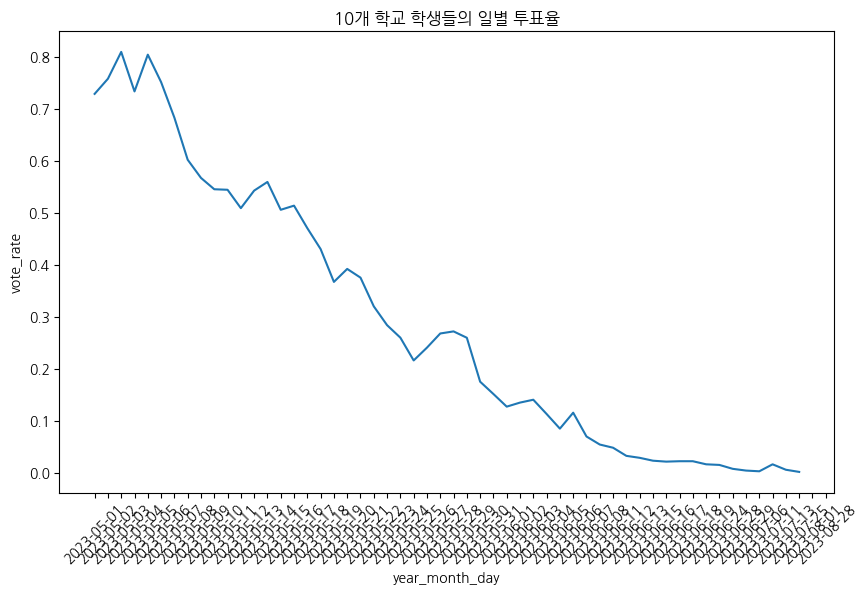

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(data=user_count_df,  x='year_month_day', y='vote_rate')
plt.title('10개 학교 학생들의 일별 투표율')
plt.xticks(rotation=45)
plt.show()

- 분모의 가입자는 계속 늘어남. 누적 가입 인원이기 때문에
- 투표율이 줄어드는 것은 어쨌든, 서비스에 지속적인 흥미를 느끼지 못하고 유저들이 앱에 들어왔으나 투표를 안하고 나갔거나 / 단발성으로 회원가입 후 한두번 투표 해보고 재방문을 안했다는 의미

---

## 재투표 리텐션 확인하기

In [36]:
# 유저별 투표일, 일별 투표 수 확인하기
vote_retention_df = userquestion_school_567_df.groupby(['user_id', 'year_month_day']).size().reset_index(name='count')
vote_retention_df.head()

,user_id,year_month_day,count
0,838023,2023-05-02,1
1,838023,2023-05-03,10
2,838023,2023-05-04,4
3,838466,2023-05-02,9
4,838466,2023-05-03,34


In [37]:
# 유저별 몇번째 투표일인지 나타내기
# 첫 번째 투표일을 1 으로 표시
vote_retention_df['visit_order'] = (
    vote_retention_df
    .groupby('user_id')
    .cumcount() + 1
)
vote_retention_df.head()

,user_id,year_month_day,count,visit_order
0,838023,2023-05-02,1,1
1,838023,2023-05-03,10,2
2,838023,2023-05-04,4,3
3,838466,2023-05-02,9,1
4,838466,2023-05-03,34,2


### 리텐션 차트 구하기

In [38]:
# 데이터 복사해놓기
retentiochart_df = vote_retention_df.copy()

# 투표한 첫째날 구하기
first_visit = retentiochart_df.groupby('user_id')['year_month_day'].min().reset_index()
first_visit.columns = ['user_id', 'first_day']
first_visit.head()

,user_id,first_day
0,838023,2023-05-02
1,838466,2023-05-02
2,839357,2023-05-01
3,840293,2023-05-03
4,840473,2023-05-03


In [39]:
# 원본 데이터와 합치기
retentiochart_df = pd.merge(retentiochart_df, first_visit, on='user_id')
retentiochart_df.head()

,user_id,year_month_day,count,visit_order,first_day
0,838023,2023-05-02,1,1,2023-05-02
1,838023,2023-05-03,10,2,2023-05-02
2,838023,2023-05-04,4,3,2023-05-02
3,838466,2023-05-02,9,1,2023-05-02
4,838466,2023-05-03,34,2,2023-05-02


In [40]:
# 각 row마다 Day N (투표 기준 몇번째 일자인지) 계산
retentiochart_df['day_number'] = (pd.to_datetime(retentiochart_df['year_month_day']) - pd.to_datetime(retentiochart_df['first_day'])).dt.days
retentiochart_df.head()

,user_id,year_month_day,count,visit_order,first_day,day_number
0,838023,2023-05-02,1,1,2023-05-02,0
1,838023,2023-05-03,10,2,2023-05-02,1
2,838023,2023-05-04,4,3,2023-05-02,2
3,838466,2023-05-02,9,1,2023-05-02,0
4,838466,2023-05-03,34,2,2023-05-02,1


In [41]:
# 코호트 기준: 첫 투표일 기준으로 그룹핑
retentiochart_df['cohort'] = retentiochart_df['first_day']
retentiochart_df.head()

,user_id,year_month_day,count,visit_order,first_day,day_number,cohort
0,838023,2023-05-02,1,1,2023-05-02,0,2023-05-02
1,838023,2023-05-03,10,2,2023-05-02,1,2023-05-02
2,838023,2023-05-04,4,3,2023-05-02,2,2023-05-02
3,838466,2023-05-02,9,1,2023-05-02,0,2023-05-02
4,838466,2023-05-03,34,2,2023-05-02,1,2023-05-02


In [42]:
# 코호트별로(첫 ) 각 Day에 방문한 유저 수 집계
retention = (
    retentiochart_df.groupby(['cohort', 'day_number'])['user_id']
    .nunique()
    .unstack(fill_value=0)
)
retention.head()

day_number,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
cohort,,,,,,,,,,,,,,,,,,,,,
2023-05-01,325,310,285,228,229,222,195,154,128,118,...,0,2,0,4,2,1,3,3,2,4
2023-05-02,103,83,74,71,70,61,47,45,47,35,...,0,0,1,1,0,0,2,0,1,0
2023-05-03,388,350,356,339,317,264,235,194,163,129,...,2,0,2,0,0,0,0,3,0,0
2023-05-04,168,156,152,141,107,93,83,71,56,40,...,0,0,0,0,0,0,0,0,0,0
2023-05-05,436,409,374,331,259,248,191,164,138,146,...,1,0,1,0,1,0,0,0,0,0


In [43]:
retention[[0]]

day_number,0
cohort,
2023-05-01,325
2023-05-02,103
2023-05-03,388
2023-05-04,168
2023-05-05,436
2023-05-06,183
2023-05-07,105
2023-05-08,149
2023-05-09,231


In [44]:
# 각 코호트의 Day 0 유저 수로 나눠 비율(%) 계산
cohort_sizes = retention[0]
retention_rate = retention.divide(cohort_sizes, axis=0) * 100  # %로
retention_rate = retention_rate.round(1)
retention_rate.head()

day_number,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
cohort,,,,,,,,,,,,,,,,,,,,,
2023-05-01,100.0,95.4,87.7,70.2,70.5,68.3,60.0,47.4,39.4,36.3,...,0.0,0.6,0.0,1.2,0.6,0.3,0.9,0.9,0.6,1.2
2023-05-02,100.0,80.6,71.8,68.9,68.0,59.2,45.6,43.7,45.6,34.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.9,0.0,1.0,0.0
2023-05-03,100.0,90.2,91.8,87.4,81.7,68.0,60.6,50.0,42.0,33.2,...,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.8,0.0,0.0
2023-05-04,100.0,92.9,90.5,83.9,63.7,55.4,49.4,42.3,33.3,23.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,33.5,...,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0


In [45]:
# 재투표율 리텐션 비율을 구한 데이터프레임의 제일 첫번째에 해당 cohort의 그룹 수를 넣어보기

# 유저 수 추출
user_cnt = retention[0]
# 데이터프레임으로 변환
user_cnt = user_cnt.to_frame(name='user_count')
# 재투표율 리텐션 비율을 구한 데이터프레임에 합치기
retention_with_usercount_df = pd.concat([user_cnt,retention_rate], axis=1)
retention_with_usercount_df.tail(30)

,user_count,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
cohort,,,,,,,,,,,,,,,,,,,,,
2023-05-24,68,100.0,76.5,75.0,70.6,69.1,63.2,50.0,39.7,29.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-25,31,100.0,87.1,80.6,71.0,71.0,58.1,45.2,35.5,45.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-26,19,100.0,73.7,63.2,78.9,57.9,57.9,63.2,52.6,36.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-27,22,100.0,81.8,63.6,54.5,59.1,40.9,36.4,40.9,31.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-28,14,100.0,85.7,71.4,57.1,35.7,71.4,64.3,35.7,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-29,24,100.0,62.5,62.5,33.3,45.8,41.7,33.3,33.3,33.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-30,18,100.0,72.2,44.4,61.1,55.6,55.6,55.6,50.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-31,7,100.0,42.9,42.9,57.1,28.6,28.6,28.6,28.6,28.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-01,1,100.0,0.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 리텐션 차트의 기간은?

- 일단, cohort의 수가 너무 적으면 안됨
    - 기준은 중심극한정리 (Central Limit Theorem)
    - 표본 크기 n 이 충분히 크면, 어떤 분포에서 추출한 표본의 평균 분포는 정규분포에 가까워진다.
    - 통계 실무에서는 **표본 크기 n \geq 30**이면 “충분히 크다”고 보고, 평균이 정규분포를 따른다고 가정

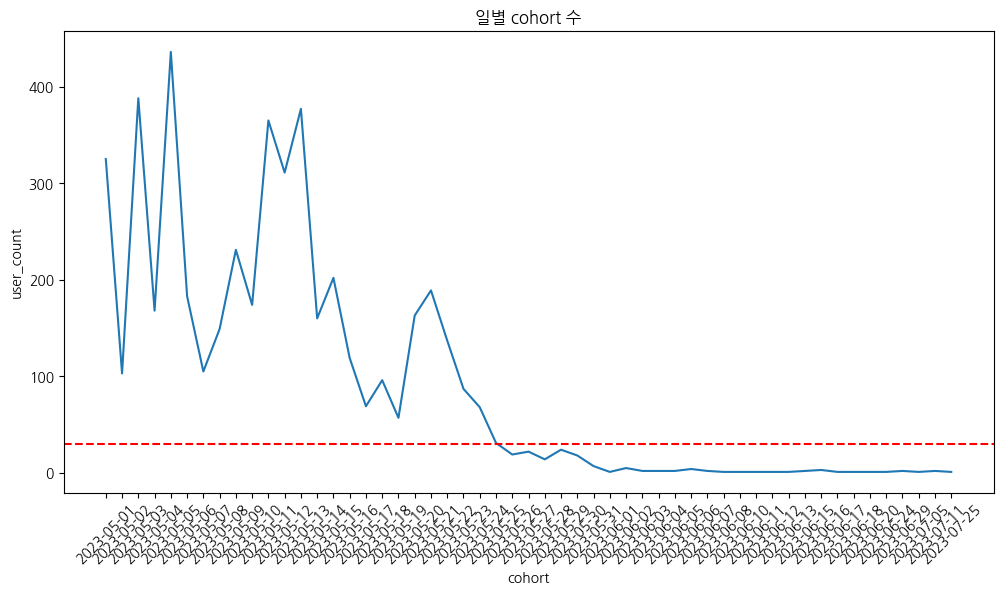

In [46]:
# 집단별 표본 크기 그래프로 그려보기

plt.figure(figsize=(12,6))
sns.lineplot(data=retention_with_usercount_df, x='cohort', y='user_count')
# y=30 기준선 추가 (점선)
plt.axhline(y=30, color='red', linestyle='--', linewidth=1.5, label='n = 30 기준선')
plt.title('일별 cohort 수')
plt.xticks(rotation=45)
plt.show()

In [47]:
retention_with_usercount_df[retention_with_usercount_df['user_count'] <= 30]

,user_count,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
cohort,,,,,,,,,,,,,,,,,,,,,
2023-05-26,19,100.0,73.7,63.2,78.9,57.9,57.9,63.2,52.6,36.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-27,22,100.0,81.8,63.6,54.5,59.1,40.9,36.4,40.9,31.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-28,14,100.0,85.7,71.4,57.1,35.7,71.4,64.3,35.7,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-29,24,100.0,62.5,62.5,33.3,45.8,41.7,33.3,33.3,33.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-30,18,100.0,72.2,44.4,61.1,55.6,55.6,55.6,50.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-31,7,100.0,42.9,42.9,57.1,28.6,28.6,28.6,28.6,28.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-01,1,100.0,0.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-02,5,100.0,100.0,60.0,100.0,60.0,40.0,60.0,40.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,2,100.0,100.0,100.0,100.0,50.0,0.0,0.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 기간은 표본 크기가 30 이상인 5/1 ~ 5/25

In [48]:
retention_with_usercount_df[retention_with_usercount_df['user_count'] > 30]

,user_count,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
cohort,,,,,,,,,,,,,,,,,,,,,
2023-05-01,325,100.0,95.4,87.7,70.2,70.5,68.3,60.0,47.4,39.4,...,0.0,0.6,0.0,1.2,0.6,0.3,0.9,0.9,0.6,1.2
2023-05-02,103,100.0,80.6,71.8,68.9,68.0,59.2,45.6,43.7,45.6,...,0.0,0.0,1.0,1.0,0.0,0.0,1.9,0.0,1.0,0.0
2023-05-03,388,100.0,90.2,91.8,87.4,81.7,68.0,60.6,50.0,42.0,...,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.8,0.0,0.0
2023-05-04,168,100.0,92.9,90.5,83.9,63.7,55.4,49.4,42.3,33.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-05,436,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,...,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0
2023-05-06,183,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-07,105,100.0,89.5,73.3,72.4,55.2,50.5,55.2,43.8,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-08,149,100.0,80.5,77.9,83.9,66.4,61.1,61.7,50.3,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-09,231,100.0,91.3,88.7,83.1,84.4,84.0,76.2,72.7,73.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 하위 지표 확인하기

- 우리의 목표 리텐션은 50% 유지
    - 일자별 리텐션을 계산했을 때 50%가 깨지는 일차인 7일차를 기준으로 코호트를 확인
        - 7일차에서 리텐션이 가장 높은 집단 : 5/20 (73%)
        - 7일차에서 리텐션이 가장 낮은 집단 : 5/17 (33.3%)

### 리텐션 가장 높은 집단 (5/20)

In [50]:
retention_0520_df = retentiochart_df[retentiochart_df['first_day'] == '2023-05-20']
retention_0520_df.head()

,user_id,year_month_day,count,visit_order,first_day,day_number,cohort
1988,855230,2023-05-20,28,1,2023-05-20,0,2023-05-20
1989,855230,2023-05-21,120,2,2023-05-20,1,2023-05-20
1990,855230,2023-05-22,44,3,2023-05-20,2,2023-05-20
1991,855230,2023-05-23,22,4,2023-05-20,3,2023-05-20
1992,855230,2023-05-24,34,5,2023-05-20,4,2023-05-20


In [54]:
user_0520_list = list(retention_0520_df['user_id'].unique())

### 리텐션 가장 낮은 집단 (5/17)

In [51]:
retention_0517_df = retentiochart_df[retentiochart_df['first_day'] == '2023-05-17']
retention_0517_df.head()

,user_id,year_month_day,count,visit_order,first_day,day_number,cohort
15993,899988,2023-05-17,25,1,2023-05-17,0,2023-05-17
15994,899988,2023-05-18,17,2,2023-05-17,1,2023-05-17
15995,899988,2023-05-19,7,3,2023-05-17,2,2023-05-17
15996,899988,2023-05-20,3,4,2023-05-17,3,2023-05-17
15997,899988,2023-05-21,36,5,2023-05-17,4,2023-05-17


In [55]:
user_0517_list = list(retention_0517_df['user_id'].unique())

### 질문 카테고리 데이터
- 집단별 어떤 카테고리를 투표한 기록이 많았는지 확인해보기

In [52]:
question_category_df = pd.read_parquet('./polls_question_add_category.parquet')
question_category_df.head()

,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,"[연애, 성격, 감성]"
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,"[심리, 상상, 인간관계]"
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,"[미디어, 미래, 상상]"
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,"[성격, 관찰, 인간관계]"
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,"[심리, 일상, 인간관계]"


In [65]:
# 투표 기록 테이블
userquestionrecord_df = pd.read_parquet('votes/accounts_userquestionrecord.parquet') 
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [67]:
userquestionrecord_df.columns

Index(['id', 'status', 'created_at', 'chosen_user_id', 'question_id',
       'user_id', 'question_piece_id', 'has_read', 'answer_status',
       'answer_updated_at', 'report_count', 'opened_times'],
      dtype='object')

In [72]:
# 투표 기록에서 필요한 정보만 추출하기
userquestionrecord_cohort_df = userquestionrecord_df[['status', 'created_at', 'user_id', 'question_piece_id','answer_status']]

# 2023-05-01 ~ 25 기간 데이터 추리기
userquestionrecord_cohort_df = userquestionrecord_cohort_df[(userquestionrecord_cohort_df['created_at']>='2023-05-01')&(userquestionrecord_cohort_df['created_at']<'2023-05-26')]

# user_0520_list 와 유저id가 일치하면 cohort라는 컬럼에 1을 넣고
# user_0517_list 와 유저id가 일치하면 cohort라는 컬럼에 2을 넣고
# 일치하는게 없다면 결측값 처리하기

userquestionrecord_cohort_df['cohort'] = userquestionrecord_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_0520_list
    else (2 if x in user_0517_list else np.nan)
)

userquestionrecord_cohort_df.head()

,status,created_at,user_id,question_piece_id,answer_status,cohort
30798,C,2023-05-01 03:37:42,857913,1821408,N,NaN
30799,C,2023-05-01 03:38:24,856430,1861799,N,NaN
30800,C,2023-05-01 03:38:38,856430,1861800,N,NaN
30801,C,2023-05-01 03:38:48,856430,1861801,N,NaN
30802,C,2023-05-01 03:38:53,856430,1861802,N,NaN


In [75]:
# cohort가 결측값인 데이터 버리기
userquestionrecord_cohort_df = userquestionrecord_cohort_df[~userquestionrecord_cohort_df['cohort'].isna()]
userquestionrecord_cohort_df.head()

,status,created_at,user_id,question_piece_id,answer_status,cohort
679310,C,2023-05-17 00:13:52,1318782,74392592,A,2.0
679313,C,2023-05-17 00:14:05,1318782,74392595,N,2.0
679318,C,2023-05-17 00:14:15,1318782,74392600,N,2.0
679321,C,2023-05-17 00:14:25,1318782,74392602,A,2.0
679722,C,2023-05-17 00:29:46,1339039,80099800,A,2.0


- 질문 테이블과 합치기

In [76]:
# 질문 테이블
polls_questionpiece_df = pd.read_parquet('votes/polls_questionpiece.parquet') 
polls_questionpiece_df.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [78]:
# userquestionrecord_cohort_df와 polls_questionpiece_df 합치기
question_cohort_df = pd.merge(userquestionrecord_cohort_df, polls_questionpiece_df, left_on='question_piece_id', right_on='id', how='left')
question_cohort_df.head()

,status,created_at_x,user_id,question_piece_id,answer_status,cohort,id,is_voted,created_at_y,question_id,is_skipped
0,C,2023-05-17 00:13:52,1318782,74392592,A,2.0,74392592,1,2023-05-16 10:07:08,1423,0
1,C,2023-05-17 00:14:05,1318782,74392595,N,2.0,74392595,1,2023-05-16 10:07:08,1627,0
2,C,2023-05-17 00:14:15,1318782,74392600,N,2.0,74392600,1,2023-05-16 10:07:08,737,0
3,C,2023-05-17 00:14:25,1318782,74392602,A,2.0,74392602,1,2023-05-16 10:07:08,1294,0
4,C,2023-05-17 00:29:46,1339039,80099800,A,2.0,80099800,1,2023-05-17 00:25:48,1277,0


In [79]:
# 필요없는 컬럼 날리기
question_cohort_df = question_cohort_df.drop(columns=['created_at_x', 'id', 'created_at_y'])

# question_category_df 와 합치기
question_category_cohort_df = pd.merge(question_cohort_df, question_category_df, left_on='question_id', right_on='id', how='left')
question_category_cohort_df.head()

,status,user_id,question_piece_id,answer_status,cohort,is_voted,question_id,is_skipped,id,question_text,created_at,category
0,C,1318782,74392592,A,2.0,1,1423,0,1423,혼자서도 잘 놀 것 같은 사람은?,2023-05-15 14:03:28,"[일상, 성격, 라이프스타일]"
1,C,1318782,74392595,N,2.0,1,1627,0,1627,빼빼로게임 같이 하고 싶은 사람,2023-05-15 14:04:51,"[연애, 일상, 대화]"
2,C,1318782,74392600,N,2.0,1,737,0,737,"봉준호, BTS, 손흥민, ○○○ Let's go",2023-05-15 13:58:40,"[미디어, 미래, 일상]"
3,C,1318782,74392602,A,2.0,1,1294,0,1294,취하면 독특한 주사를 가질 것 같은 사람,2023-05-15 14:02:36,"[심리, 일상, 성격]"
4,C,1339039,80099800,A,2.0,1,1277,0,1277,지구 멸망하기 1시간 전에 보러가고 싶은 사람은?,2023-05-15 14:02:28,"[감성, 미래, 상상]"


In [80]:
# category 컬럼이 리스트형태, explode로 키워드 분해
df_category_exploded = question_category_cohort_df.explode('category')
df_category_exploded.head()

,status,user_id,question_piece_id,answer_status,cohort,is_voted,question_id,is_skipped,id,question_text,created_at,category
0,C,1318782,74392592,A,2.0,1,1423,0,1423,혼자서도 잘 놀 것 같은 사람은?,2023-05-15 14:03:28,일상
0,C,1318782,74392592,A,2.0,1,1423,0,1423,혼자서도 잘 놀 것 같은 사람은?,2023-05-15 14:03:28,성격
0,C,1318782,74392592,A,2.0,1,1423,0,1423,혼자서도 잘 놀 것 같은 사람은?,2023-05-15 14:03:28,라이프스타일
1,C,1318782,74392595,N,2.0,1,1627,0,1627,빼빼로게임 같이 하고 싶은 사람,2023-05-15 14:04:51,연애
1,C,1318782,74392595,N,2.0,1,1627,0,1627,빼빼로게임 같이 하고 싶은 사람,2023-05-15 14:04:51,일상


In [81]:
# 키워드 수 세기 (cohort별로)
category_count_df = df_category_exploded.groupby(['cohort', 'category']).size().reset_index(name='count')
category_count_df.head()

,cohort,category,count
0,1.0,감성,5860
1,1.0,건강,19
2,1.0,관찰,11459
3,1.0,기억,21
4,1.0,대화,3032


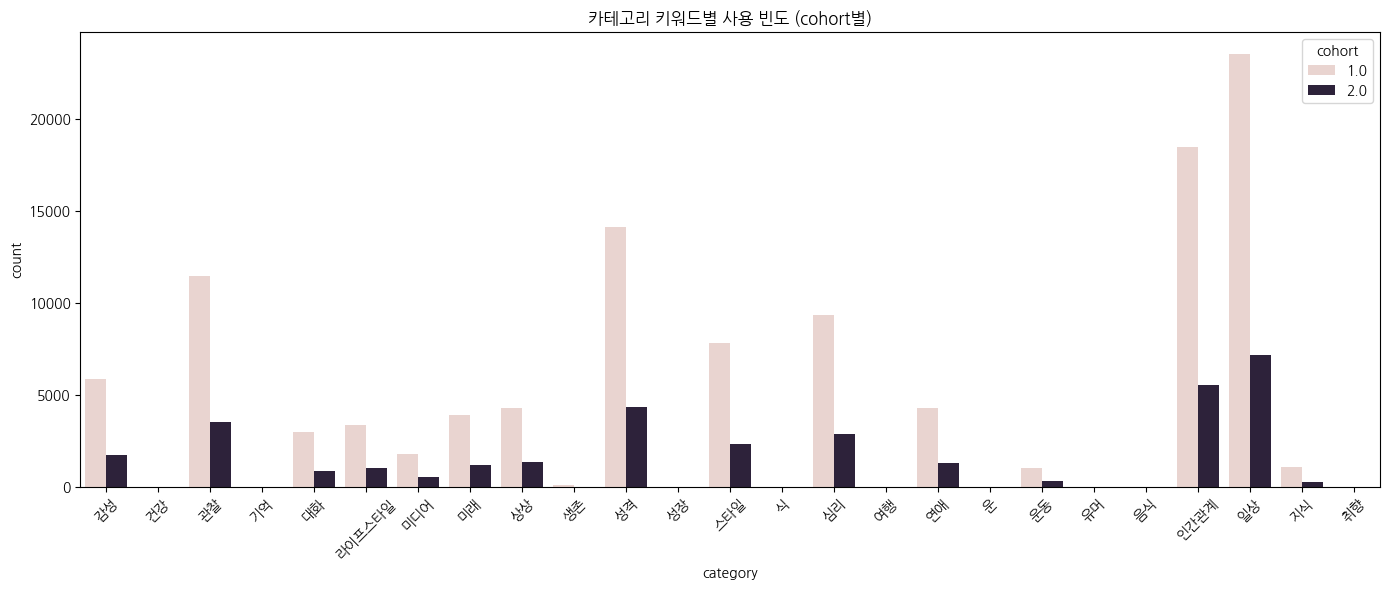

In [82]:
# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(
    data=category_count_df,
    x='category',
    y='count',
    hue='cohort'
)
plt.xticks(rotation=45)
plt.title('카테고리 키워드별 사용 빈도 (cohort별)')
plt.tight_layout()
plt.show()

- 각 코호트별 키워드 빈도수 내림차순

In [83]:
# 1번 집단
category_count_cohort1_df = category_count_df[category_count_df['cohort']==1]
# 키워드 내림차순
category_count_cohort1_df.sort_values(by='count', ascending=False)

,cohort,category,count
22,1.0,일상,23528
21,1.0,인간관계,18495
10,1.0,성격,14148
2,1.0,관찰,11459
14,1.0,심리,9337
12,1.0,스타일,7845
0,1.0,감성,5860
8,1.0,상상,4320
16,1.0,연애,4304
7,1.0,미래,3930


In [84]:
# 2번 집단
category_count_cohort2_df = category_count_df[category_count_df['cohort']==2]
# 키워드 내림차순
category_count_cohort2_df.sort_values(by='count', ascending=False)

,cohort,category,count
47,2.0,일상,7176
46,2.0,인간관계,5565
35,2.0,성격,4357
27,2.0,관찰,3528
39,2.0,심리,2881
37,2.0,스타일,2382
25,2.0,감성,1747
33,2.0,상상,1354
41,2.0,연애,1318
32,2.0,미래,1193


---

### 집단별 구매율 차이

In [56]:
# 구매 기록 테이블
paymenthistory_df = pd.read_parquet('votes/accounts_paymenthistory.parquet') 
paymenthistory_df.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [57]:
# user_0520_list 와 유저id가 일치하면 cohort라는 컬럼에 1을 넣고
# user_0517_list 와 유저id가 일치하면 cohort라는 컬럼에 2을 넣고
# 일치하는게 없다면 결측값 처리하기

paymenthistory_cohort_df = paymenthistory_df.copy()

paymenthistory_cohort_df['cohort'] = paymenthistory_cohort_df['user_id'].apply(
    lambda x : 1 if x in user_0520_list
    else (2 if x in user_0517_list else np.nan) 
    )

paymenthistory_cohort_df.head()

,id,productId,phone_type,created_at,user_id,cohort
0,6,heart.777,A,2023-05-13 21:28:34,1211127,NaN
1,7,heart.777,A,2023-05-13 21:29:39,1151343,NaN
2,8,heart.777,A,2023-05-13 21:31:33,1002147,NaN
3,9,heart.777,A,2023-05-13 21:31:39,1095040,NaN
4,11,heart.777,A,2023-05-13 21:34:32,1164081,NaN


In [ ]:
# 두 집단에 해당하는 데이터는 54개뿐.
# 결측값은 cohort 컬럼에만 있음
paymenthistory_cohort_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
 5   cohort      54 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.4+ MB


In [68]:
# 결측값 제거
paymenthistory_cohort_df = paymenthistory_cohort_df.dropna()

# 날짜가 2023-05-01~25 일까지!!!
paymenthistory_cohort_df = paymenthistory_cohort_df[(paymenthistory_cohort_df['created_at']>='2023-05-01')&(paymenthistory_cohort_df['created_at']<'2023-05-26')]

# 구매율 구해보기

# 코호트별 수 구하기
paymenthistory_cohort_group_df = paymenthistory_cohort_df.groupby(['cohort']).size().reset_index(name='payment_count')
# 전체 코호트에서 비율 구하기
# user 리스트 길이
user_0520_count = len(user_0520_list)
user_0517_count = len(user_0517_list)

paymenthistory_cohort_group_df['payment_rate'] = paymenthistory_cohort_group_df.apply(
    lambda row : row['payment_count'] / user_0520_count if row['cohort'] == 1
    else (row['payment_count'] / user_0517_count if row['cohort'] == 2 else np.nan),
    axis=1
)

paymenthistory_cohort_group_df.head()

,cohort,payment_count,payment_rate
0,1.0,31,0.190184
1,2.0,16,0.231884


In [69]:
print(user_0520_count, user_0517_count)

163 69


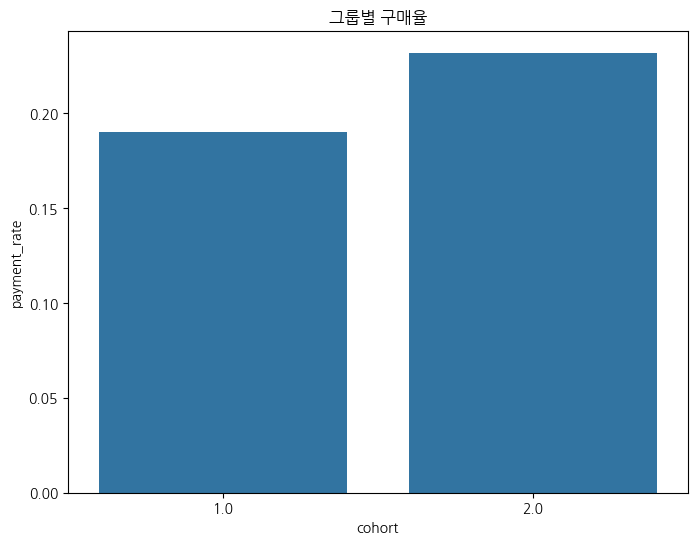

In [70]:
# 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=paymenthistory_cohort_group_df, x='cohort', y='payment_rate')
plt.title('그룹별 구매율')
plt.show()

---

###